 # Diplomatura en Ciencas de Datos, Aprendizaje Automático y sus Aplicaciones

 Autores: Matias Oria, Antonela Sambuceti, Pamela Pairo, Benjamín Ocampo

 Inicilamente definiremos algunas funciones, constantes y nombres de variables
 que utilizaremos durante nuestro análisis.

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

URL = "https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv"
DB = pd.read_csv(URL)

MINWAGE_IN_ARG = 18600

profile_years_experience = "profile_years_experience"
salary_in_usd = "salary_in_usd"
salary_monthly_NETO = "salary_monthly_NETO"
tools_programming_language = "tools_programming_languages"
work_contract_type = "work_contract_type"

def split_languages(languages_str):
    if not isinstance(languages_str, str):
        return []

    for label in ['ninguno de los anteriores', 'ninguno']:
        languages_str = languages_str.lower().replace(label, '')

    return [lang.strip().replace(',', '') for lang in languages_str.split()]


def stack_col(df, stacked_col, unstacked_col):
    return df[unstacked_col] \
        .apply(pd.Series).stack()\
        .reset_index(level=-1, drop=True).to_frame()\
        .join(df)\
        .rename(columns={0: stacked_col})


def add_cured_col(df, uncured_col, cured_col, cure_func):
    df.loc[:, cured_col] = df[uncured_col] \
        .apply(cure_func)
    return df


def min_central_tendency(df, col, max_threshold):
    tendency = [
        (
            threshold,
            df[df[col] > threshold][col].mean(),
            df[df[col] > threshold][col].median()
        )
        for threshold in range(df[col].min(), max_threshold)
    ]

    tendency_df = pd.DataFrame(tendency, columns=['threshold', 'mean', 'median'])
    tendency_df["distance"] = abs(tendency_df["mean"] - tendency_df["median"])
    best_threshold = tendency_df.idxmin()["distance"]

    return (
        tendency_df.melt(id_vars='threshold', var_name='metric'),
        best_threshold
    )


 ## Agrupamiento por lenguages de programación
 Trabajaremos con el dataset dado por la Encuesta Sysarmy del año 2020. Ahora
 bien, antes de abordar el problema, agregaremos la columna adicional
 `cured_programming_language` a nuestro dataset utilizando la función
 `add_cured_col` donde a cada uno de los lenguajes de programación dados por la
 columna `tools_programming_language`, se los separa en listas de python. Luego
 apilamos sobre cada empleado, sus lenguajes de programación utilizados dados
 por la columna curada utilizando la función `stack_col` para obtener el
 siguiente dataframe.

In [2]:
cured_programming_languages = "cured_programming_languages"
programming_language = "programming_language"

df = DB.copy() \
    .pipe(
        add_cured_col,
        cured_col=cured_programming_languages,
        uncured_col=tools_programming_language,
        cure_func=split_languages
    ).pipe(
        stack_col,
        stacked_col=programming_language,
        unstacked_col=cured_programming_languages
    ).reset_index(drop=True)

df

,programming_language,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,...,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city,cured_programming_languages
0,html,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,...,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN,"[html, javascript, python]"
1,javascript,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,...,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN,"[html, javascript, python]"
2,python,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,...,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN,"[html, javascript, python]"
3,bash/shell,Hombre,39,Argentina,Corrientes,15.0,15.0,13.0,5,Posgrado,...,Heterosexual,NaN,NaN,501-1000,Otras industrias,7,6,"Abono de celular, Capacitaciones y/o cursos, C...",NaN,"[bash/shell, c, css, html, java, javascript, p..."
4,c,Hombre,39,Argentina,Corrientes,15.0,15.0,13.0,5,Posgrado,...,Heterosexual,NaN,NaN,501-1000,Otras industrias,7,6,"Abono de celular, Capacitaciones y/o cursos, C...",NaN,"[bash/shell, c, css, html, java, javascript, p..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17669,java,Hombre,28,Argentina,La Pampa,5.0,3.0,2.0,0,Terciario,...,Heterosexual,NaN,No,51-100,Servicios / Consultoría de Software / Digital,5,7,Capacitaciones y/o cursos,Solo Nubity,"[c, c++, html, java, javascript, php, python, ..."
17670,javascript,Hombre,28,Argentina,La Pampa,5.0,3.0,2.0,0,Terciario,...,Heterosexual,NaN,No,51-100,Servicios / Consultoría de Software / Digital,5,7,Capacitaciones y/o cursos,Solo Nubity,"[c, c++, html, java, javascript, php, python, ..."
17671,php,Hombre,28,Argentina,La Pampa,5.0,3.0,2.0,0,Terciario,...,Heterosexual,NaN,No,51-100,Servicios / Consultoría de Software / Digital,5,7,Capacitaciones y/o cursos,Solo Nubity,"[c, c++, html, java, javascript, php, python, ..."
17672,python,Hombre,28,Argentina,La Pampa,5.0,3.0,2.0,0,Terciario,...,Heterosexual,NaN,No,51-100,Servicios / Consultoría de Software / Digital,5,7,Capacitaciones y/o cursos,Solo Nubity,"[c, c++, html, java, javascript, php, python, ..."


 ## Analisis descriptivo
 Para la respuesta a la pregunta **¿Cuáles son los lenguajes de programación
 asociados a los mejores salarios?** hay varios factores a tener en cuenta
 además del salario neto de los empleados, tales como, el tipo de contrato
 (Full Time o Part Time), si su sueldo está dolarizado o no, los años de
 experiencia, su rol de trabajo, entre otras que pueden dificultar el analisis
 de la pregunta si no nos enfocamos en una subpoblación del total de
 trabajadores. Por lo tanto, para hacer una comparación más justa optamos por
 considerar aquellos empleados que cumplan lo siguiente:

 - Contrato Full Time: Dependiendo de la cantidad de horas que se empeñe en el
   rol el salario podría verse influenciado. Por ende consideramos solamente el
   de mayor carga horaria.
 - A lo sumo 5 años de experiencia: Nos interesará saber que lenguajes otorgan
   los mejores salarios en los primeros años de trabajo.
 - Un salario neto mayor al minimo vital y móvil en la Argentina: Filtraremos
   además aquellos empleados que no superen el salario mínimo para empleados
   mensualizados.

 Esto llevó a la selección de las siguientes variables aleatorias relevantes
 `rvs`.

In [3]:
rvs = [
    programming_language,
    work_contract_type,
    profile_years_experience,
    salary_in_usd,
    salary_monthly_NETO,
]

df = df[
    (df[work_contract_type] == "Full-Time") &
    (df[salary_monthly_NETO] > MINWAGE_IN_ARG) &
    (df[profile_years_experience] <= 5) &
    (df[salary_in_usd] != "Mi sueldo está dolarizado")
][rvs]

df

,programming_language,work_contract_type,profile_years_experience,salary_in_usd,salary_monthly_NETO
0,html,Full-Time,5.0,NaN,63000.0
1,javascript,Full-Time,5.0,NaN,63000.0
2,python,Full-Time,5.0,NaN,63000.0
17,java,Full-Time,1.0,NaN,44000.0
18,javascript,Full-Time,1.0,NaN,44000.0
...,...,...,...,...,...
17643,html,Full-Time,2.0,NaN,53784.0
17644,javascript,Full-Time,2.0,NaN,53784.0
17645,python,Full-Time,2.0,NaN,53784.0
17646,sql,Full-Time,2.0,NaN,53784.0


 ## Lenguajes de Programación más Populares
 Para cada lenguaje de programación obtenemos el conteo de su frecuencia junto
 a su salario neto promedio.

In [4]:
count_bylangs = df.groupby(programming_language).agg(
    salary_monthly_NETO_mean=(salary_monthly_NETO, "mean"),
    count=(programming_language, "count")
)

count_bylangs.sort_values(by="salary_monthly_NETO_mean", ascending=False).head(20)


,salary_monthly_NETO_mean,count
programming_language,,
|,125000.000000,1
ansible,125000.000000,1
twig,120000.000000,1
sass,120000.000000,1
lua,104654.000000,1
objective-c,102357.000000,14
nosql,102000.000000,1
json,100000.000000,1
terraform,97000.000000,1


 Notar que si bien hay algunos lenguajes que tienen sueldos muy altos, su
 frecuencia es muy baja, siendo muy poco representativo. Por lo tanto
 ordenaremos por frecuencia.

In [5]:
count_bylangs.sort_values(by="count", ascending=False).head(20)


,salary_monthly_NETO_mean,count
programming_language,,
javascript,66815.606256,820
sql,64110.938684,646
html,62591.117942,583
java,71301.472026,454
css,63425.775394,432
python,73332.446574,394
typescript,70895.763488,258
.net,62093.026694,248
c#,61889.053170,224


 Ahora bien, ¿Cuantos empleados deben utilizar el lenguaje para ser considerado
 popular?. Si analizamos la tendencia central de la frecuencia podremos
 determinar que cantidad es representantiva. Para ello, tomamos umbrales entre
 $\{1, ... , 100\}$ calculando la media y mediana para los lenguajes de
 programación que tengan una frecuencia mayor a cada uno de esos umbrales y
 seleccionando el umbral que minimice la distancia entre estas medidas. Esto
 lo hacemos a través de la función `min_central_tendency` siendo 100 el umbral
 máximo a considerar bajo el dataframe obtenido en la celda anterior.

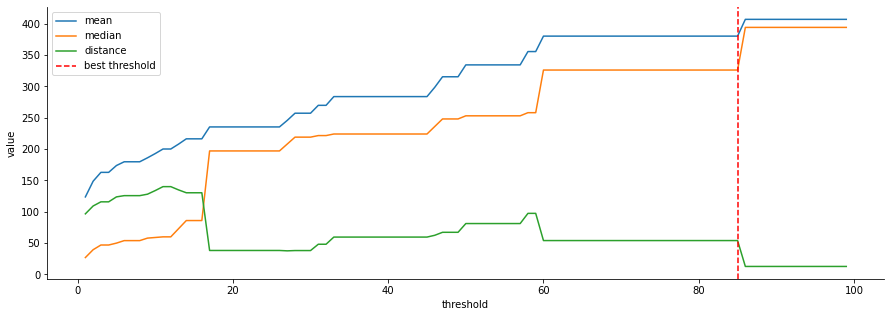

In [6]:
max_threshold = 100

tendency_df, best_threshold = min_central_tendency(
    count_bylangs,
    "count",
    max_threshold
)

fig = plt.figure(figsize=(15, 5))
seaborn.lineplot(
    data=tendency_df,
    x="threshold", y="value", hue="metric"
)
plt.axvline(best_threshold, color="r", linestyle="--", label="best threshold")
plt.legend()
plt.ticklabel_format(style="plain", axis="x")
seaborn.despine()


 Puede verse a través de la gráfica para los distintos umbrales cuales son los
 valores de la media y mediana después del filtro, dando como menor distancia
 para el umbral marcado a partir de las lineas punteadas.

In [7]:
best_langs = count_bylangs[count_bylangs["count"] >= best_threshold]
best_langs

,salary_monthly_NETO_mean,count
programming_language,,
.net,62093.026694,248
bash/shell,71382.101050,219
c#,61889.053170,224
css,63425.775394,432
go,87904.836744,86
html,62591.117942,583
java,71301.472026,454
javascript,66815.606256,820
php,60990.365635,197


In [8]:

best_langs.join(
    best_langs["count"] \
        .apply(lambda count: count / best_langs["count"].sum() * 100) \
        .round(2) \
        .to_frame() \
        .rename(columns={"count": "percentage"})
        
    ).sort_values(by="salary_monthly_NETO_mean", ascending=False)


,salary_monthly_NETO_mean,count,percentage
programming_language,,,
go,87904.836744,86,1.89
python,73332.446574,394,8.64
bash/shell,71382.101050,219,4.80
java,71301.472026,454,9.95
typescript,70895.763488,258,5.66
javascript,66815.606256,820,17.98
sql,64110.938684,646,14.16
css,63425.775394,432,9.47
html,62591.117942,583,12.78


 Notar que del total de empleados que utilizan estos 12 lenguajes, el 1.89%
 tienen el mejor salario neto promedio y utilizan **Go** para programar. Luego
 les siguen **Python** con el 8.64% y **Bash/Shell y Java** con 4.80% y 9.95%
 respectivamente. Notar que en el caso de **Javascript** es el más popular con
 un 18% y un salario no muy alejado de
 los primeros puestos.

 ## Distribución de salario por lenguaje
 Utilizaremos la lista de lenguajes anterior, para obtener la distribución de
 salarios por cada uno de ellos para el dataset filtrado por las condiciones
 iniciales.

In [9]:
df_langs = df[
    df[programming_language].isin(best_langs.index.to_list())
].reset_index(drop=True)

df_langs[[programming_language, salary_monthly_NETO]] \
    .groupby(programming_language) \
    .describe()

salary_monthly_NETO                                       \
                                   count          mean           std      min   
programming_language                                                            
.net                               248.0  62093.026694  24386.630574  19650.0   
bash/shell                         219.0  71382.101050  26050.411972  20000.0   
c#                                 224.0  61889.053170  24705.772453  19650.0   
css                                432.0  63425.775394  27728.039579  19650.0   
go                                  86.0  87904.836744  25699.779855  35900.0   
html                               583.0  62591.117942  30729.090209  19650.0   
java                               454.0  71301.472026  30494.964196  19900.0   
javascript                         820.0  66815.606256  31700.420142  19650.0   
php                                197.0  60990.365635  29589.258539  20000.0   
python                             394.0  73332.446574  27752.772712  20000.0   
sql                                646.0  64110.938684  27028.084768  19650.0   
typescript                         258.0  70895.763488  31533.479009  20000.0   

                                                              
                          25%        50%       75%       max  
programming_language                                          
.net                  41987.5  58850.000   77700.0  207000.0  
bash/shell            50000.0  69602.000   89250.0  165000.0  
c#                    41500.0  58300.000   76400.0  207000.0  
css                   42000.0  59000.000   77634.0  290000.0  
go                    71000.0  82500.000  106000.0  150000.0  
html                  42000.0  58000.000   75600.0  470000.0  
java                  48000.0  66150.000   90000.0  290000.0  
javascript            45000.0  60900.000   81953.5  470000.0  
php                   40000.0  55000.000   75281.0  290000.0  
python                54000.0  69797.275   89725.0  195000.0  
sql                   43075.0  58850.000   79000.0  290000.0  
typescript            50500.0  66200.000   84000.0  270000.0

 Antes de visualizar como distribuyen los salarios, nos interesará eliminar los
 outliers que estén a una distancia 2.5 veces su desvio estandar por cada
 lenguage.

In [10]:

dff = df_langs[[programming_language, salary_monthly_NETO]] \
    .groupby(programming_language) \
    .agg(
        mean=(salary_monthly_NETO, "mean"),
        std=(salary_monthly_NETO, "std")
    )
dff["limit"] = dff["mean"] + 2.5*dff["std"]


In [11]:
df_langs = df_langs.merge(dff, on=programming_language)
df_langs = df_langs[df_langs[salary_monthly_NETO] <= df_langs["limit"]]

In [12]:

df_langs[[programming_language, salary_monthly_NETO]] \
    .groupby(programming_language) \
    .describe()


salary_monthly_NETO                                       \
                                   count          mean           std      min   
programming_language                                                            
.net                               245.0  60880.933143  21570.658003  19650.0   
bash/shell                         217.0  70634.470645  24939.371360  20000.0   
c#                                 221.0  60466.732624  21342.113120  19650.0   
css                                422.0  61066.196611  22164.578039  19650.0   
go                                  86.0  87904.836744  25699.779855  35900.0   
html                               577.0  60777.507383  22224.415602  19650.0   
java                               447.0  69380.018568  25945.324072  19900.0   
javascript                         811.0  64971.389803  24603.400633  19650.0   
php                                193.0  58446.124508  22197.616888  20000.0   
python                             387.0  71723.472739  25188.047310  20000.0   
sql                                633.0  62080.294455  22469.797263  19650.0   
typescript                         252.0  67972.646746  24739.910275  20000.0   

                                                            
                          25%      50%       75%       max  
programming_language                                        
.net                  41950.0  58600.0   76000.0  120000.0  
bash/shell            50000.0  68000.0   88087.0  135000.0  
c#                    41500.0  58000.0   75000.0  122000.0  
css                   42000.0  58215.5   75000.0  131000.0  
go                    71000.0  82500.0  106000.0  150000.0  
html                  42000.0  58000.0   75000.0  135000.0  
java                  48000.0  65000.0   89721.0  139762.0  
javascript            45000.0  60000.0   80450.0  140000.0  
php                   40000.0  54000.0   72039.0  131840.0  
python                53950.0  68920.0   88950.0  140000.0  
sql                   43000.0  58000.0   78000.0  131000.0  
typescript            50000.0  64000.0   81500.0  140000.0

 Notar que el 25% de los empleados que utilizan **Go** cobran a lo sumo 71000
 de salario neto y el 75% 106000, posicionandose como el lenguaje mejor pago,
 llegando hasta un máximo de 150000 mensuales! También puede verse que en su
 mayoría el minimo salario está cerca del vital y móvil decretado por el país
 al momento de la encuesta (18600). También los lenguajes **Javascript**,
 **HTML**, **.NET**, y **CSS** otorgan salarios similares, ¿Distribuiran de
 manera similar? Los siguientes boxenplots muestran dicha similitud.

<AxesSubplot:xlabel='salary_monthly_NETO', ylabel='programming_language'>

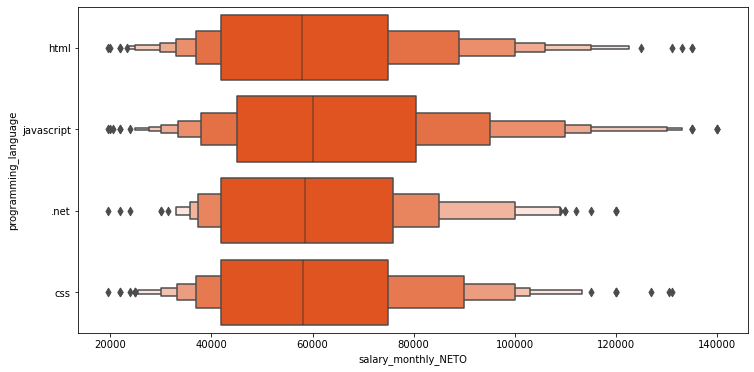

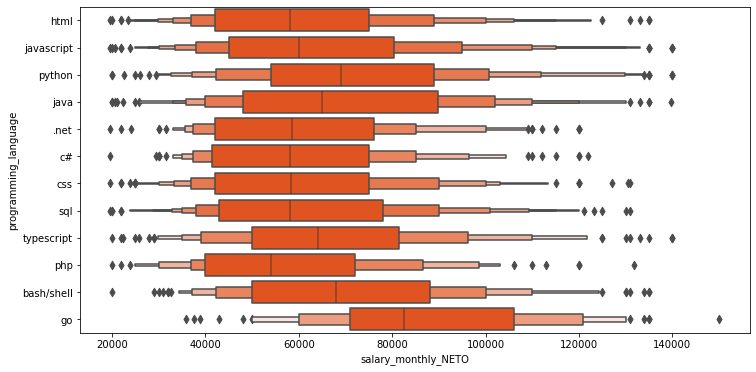

In [13]:
similar_langs = ["html", "javascript", ".net", "css"]
plt.figure(figsize=(12, 6))
seaborn.boxenplot(
    data=df_langs[df_langs[programming_language].isin(similar_langs)],
    x=salary_monthly_NETO, y=programming_language,
    color='orangered'
)
plt.ticklabel_format(style='plain', axis='x')


plt.figure(figsize=(12, 6))
seaborn.boxenplot(
    data=df_langs,
    x=salary_monthly_NETO, y=programming_language,
    color='orangered'
)


 Notar como el rango intercuartil para cada una de las distribuciones de
 salarios se encuentra por debajo de los \$100000 salvo para **Go** que
 ligeramente lo supera. Sin embargo, tenemos una asimetría o sesgo hacia los
 valores más chicos de la distribución. Lo cual nos diría que, si bien es el
 lenguaje mayor pago, un poco más del 50% tienen un salario menor que los
 \$100000. Notar como Javascript, HTML, .NET y CSS distribuyen de manera
 similar. Esto nos daría como trabajo a futuro revisar si esto se mantiene para
 distintos roles de los empleados dentro de la compañia. Por último los
 boxplots dejan en evidencia su desventaja al no tener información sobre el
 primer y el cuarto cuantiles.